In [1]:
import numpy as np
import pandas
import matplotlib.pyplot as plt

import scipy.stats

In [2]:
import sys
import requests
import importlib

def import_local_or_github(package_name, function_name=None, directory=None, giturl=None):
    # Import functions directly from github
    # Important: note that we use raw.githubusercontent.com, not github.com

    try: # to find the file locally
        if directory is not None:
            if directory not in sys.path:
                sys.path.append(directory)
    
        package = importlib.import_module(package_name)
        if function_name is not None:
            function = getattr(package, function_name)
            return function
        else:
            return package

    except: # get the file from github
        if giturl is None:
            giturl = 'https://raw.githubusercontent.com/florisvb/Nonlinear_and_Data_Driven_Estimation/main/Utility/' + str(package_name) + '.py'
        
        r = requests.get(giturl)
        print('Fetching from: ')
        print(r)
    
        # Store the file to the colab working directory
        with open(package_name+'.py', 'w') as f:
            f.write(r.text)
        f.close()
    
        # import the function we want from that file
        package = importlib.import_module(package_name)
        if function_name is not None:
            function = getattr(package, function_name)
            return function
        else:
            return package

planar_drone = import_local_or_github('planar_drone', directory='../Utility')
plot_tme = import_local_or_github('plot_utility', 'plot_tme', directory='../Utility')

/home/caveman/PY38/lib/python3.8/site-packages/do_mpc/sysid/__init__.py:15: UserWarning: The ONNX feature is not available. Please install the full version of do-mpc to access this feature.
  warnings.warn('The ONNX feature is not available. Please install the full version of do-mpc to access this feature.')
/home/caveman/PY38/lib/python3.8/site-packages/do_mpc/opcua/__init__.py:14: UserWarning: The opcua feature is not available. Please install the full version of do-mpc to access this feature.
  warnings.warn('The opcua feature is not available. Please install the full version of do-mpc to access this feature.')


# Load the data

And format it so the shapes and organization of the data matches standard mathematical notation.

### Load the arrays for the kalman filter

Colab tip: You may need to download them to your machine from notebook A, and then upload them to the colab environment where you are running this notebook.

In [3]:
# read from disk
loaded_arrays = np.load('ABCDRQ.npz')
A = loaded_arrays['A']
B = loaded_arrays['B']
C = loaded_arrays['C']
D = loaded_arrays['D']
R = loaded_arrays['R']
Q = loaded_arrays['Q']

In [4]:
print('A shape: ', A.shape)
print('B shape: ', B.shape)
print('C shape: ', C.shape)
print('D shape: ', D.shape)
print('R shape: ', R.shape)
print('Q shape: ', Q.shape)

A shape:  (7, 7)
B shape:  (7, 2)
C shape:  (4, 7)
D shape:  (4, 2)
R shape:  (4, 4)
Q shape:  (7, 7)


### Load the state data and reorganize Y and U

Standard mathematical notation requires that each column of $Y$ correspond to the measurements at discrete time, i.e. $\mathbf{y}_k$, and each row of $\mathbf{y}$ correspond to each individual measurement. Similarly for $U$. 

In [5]:
# read from disk
df_states = pandas.read_hdf('planar_drone_states.hdf')
df_measurements_true = pandas.read_hdf('planar_drone_measurements_true.hdf')
df_measurements_noisy = pandas.read_hdf('planar_drone_measurements_noisy.hdf')

In [6]:
Y = np.vstack(df_measurements_noisy[['theta', 'x', 'z', 'k']].values).T
print(Y.shape)

(4, 200)


In [7]:
U = np.vstack(df_states[['j1', 'j2']].values).T
print(U.shape)

(2, 200)


### Tip: When you index Y or U, make sure you are keeping a column vector. 

In [8]:
# This is wrong
y_0 = Y[:, 0]
print(y_0)

[0.22321732 0.81268371 0.63948923 0.99070634]


In [9]:
# This is right
y_0 = Y[:, [0]]
print(y_0)

[[0.22321732]
 [0.81268371]
 [0.63948923]
 [0.99070634]]


## Tip: matrix multiplication in python

Recall that matrix shape during multiplication works like: 

$[N\times M][M\times 1]=[N\times 1]$

In [15]:
# Option 1 using arrays
print('R shape: ', R.shape)
print('y_0 shape: ', y_0.shape)
print('[R x y_0] shape', (R@y_0).shape)
print('')
print('[R x y_0] = ')
R@y_0

R shape:  (4, 4)
y_0 shape:  (4, 1)
[R x y_0] shape (4, 1)

[R x y_0] = 


array([[2.23217318e-03],
       [3.25073486e-02],
       [1.02318277e-01],
       [9.90706342e-05]])

In [16]:
# Option 2 using matrices -- NOTE: np.matrix is getting deprecated, sadly, so this is not recommended
R_times_y_0 = np.matrix(R)*np.matrix(y_0)
print('[R x y_0] = ')
R_times_y_0

[R x y_0] = 


matrix([[2.23217318e-03],
        [3.25073486e-02],
        [1.02318277e-01],
        [9.90706342e-05]])

# Exercises:

1. Code a linear discrete Kalman filter that uses the matrices and time series data defined above:
    * $A, B, C, D, R, Q$ matrices defined above
    * Measurements are given by $Y$
    * Controls are given by $U$
    * Choose an initial $\mathbf{x_0}$ and $P_0$
    * Try a larger value of Q, and a smaller value of Q. For this problem, does a larger or smaller value of Q lead to more accurate estimates? Why do you think that is?

2. Compare the error covariance of your Kalman filter to the Cramer Rao Bound. Is your KF efficient? Try for different values of Q.

3. Compare the error covariance of your KF and the CRB to the actual errors in your estimate. Does the distribution of the errors match that predicted by the error covariance and the CRB? Hint: the error covariance and the CRB report variance, the square of the standard deviation. 

# Solution: Exercise 1: The Kalman Filter

In [17]:
def linear_discrete_kalman_forward_update(xhat_fp, P_fp, y, u, A, B, C, D, R, Q):
    """
    :param xhat_fm: prior state estimate
    :param P_fm: prior error covariance estimate
    :param y: measurements at this time step
    :param u: controls at this time step
    :param A,B,C,D: linear discrete time model 
    :param R: measurement covariance matrix 
    :param Q: process covariance matrix
    :return: current state estimate and error covariance matrix
    """
    I = np.array(np.eye(A.shape[0]))

    # predict the state and covariance for this time step given the previous estimate and the model
    xhat_fm = A@xhat_fp + B@u
    P_fm = A@P_fp@A.T + Q

    # Calculate optimal Kalman gain
    K_f = P_fm@C.T@np.linalg.pinv(C@P_fm@C.T + R)

    # If there are measurements: perform the update and predict steps
    if y is not None and not np.isnan(y).any():
        # estimate the measurements from the current state and the model
        yhat = C@xhat_fm + D@u

        # calculate the innovation
        innovation = (y - yhat)

        # Update state and covariance with optimal Kalman gain
        xhat_fp = xhat_fm + K_f@innovation
        P_fp = (I - K_f@C)@P_fm

    # If there are no measurements: cannot perform the update with innovation, so only predict forwards with the model
    else:
        xhat_fp = xhat_fm
        P_fp = (I - K_f@C)@P_fm
        
    return xhat_fp, P_fp

In [18]:
def linear_discrete_kalman_filter(x0, P0, Y, U, A, B, C, D, R, Q):
    """
    :param x0: initial state guess
    :param P0: initial state error covariance guess
    :param Y: array of all measurements
    :param U: array of all controls
    :param A,B,C,D: linear discrete time model 
    :param R: measurement covariance matrix 
    :param Q: process covariance matrix
    :return: state estimates and associated error covariance matrix
    """

    xhat_fp = x0
    P_fp = [P0]

    for i in range(Y.shape[1]):
        xhat_fp_i, P_fp_i = linear_discrete_kalman_forward_update(xhat_fp[:, [-1]], P_fp[-1], Y[:, [i]], U[:, [i]],
                                                                     A, B, C, D, R, Q)
        xhat_fp = np.hstack((xhat_fp, xhat_fp_i))
        P_fp.append(P_fp_i)

    # don't return that last element to keep size same as t
    return xhat_fp[:,1:], P_fp[1:]

### Initialize x0 and P

In [19]:
x0 = np.atleast_2d([1]*A.shape[0]).T
print('x0 shape: ', x0.shape)

P0 = np.eye(A.shape[0])*100
print('P0 shape: ', P0.shape)

x0 shape:  (7, 1)
P0 shape:  (7, 7)


### Run the Kalman filter

In [20]:
xhat_fp, P_fp = linear_discrete_kalman_filter(x0, P0, Y, U, A, B, C, D, R, Q)

### Plot some state estimates

<Axes: xlabel='Time', ylabel='x'>

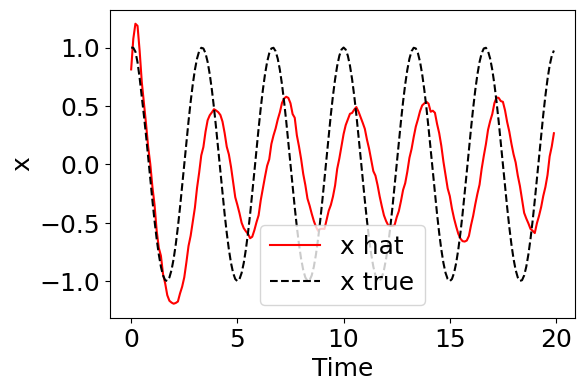

In [21]:
plot_tme(df_states.t, df_states['x'], None, estimated=xhat_fp[2,:], label_var='x')

<Axes: xlabel='Time', ylabel='theta'>

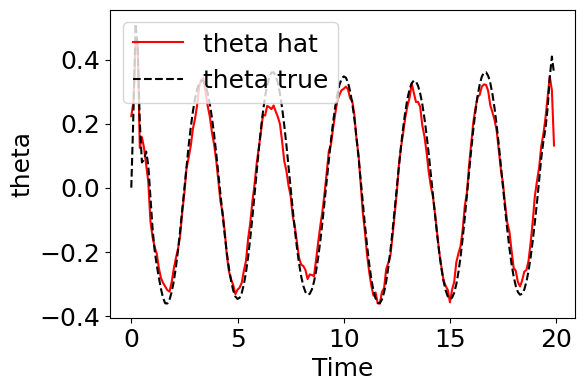

In [22]:
plot_tme(df_states.t, df_states['theta'], None, estimated=xhat_fp[0,:], label_var='theta')

### Kalman filter with a larger Q (less trust in the model)

<Axes: xlabel='Time', ylabel='theta'>

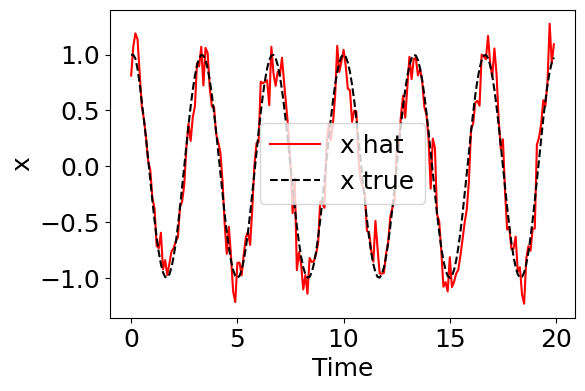

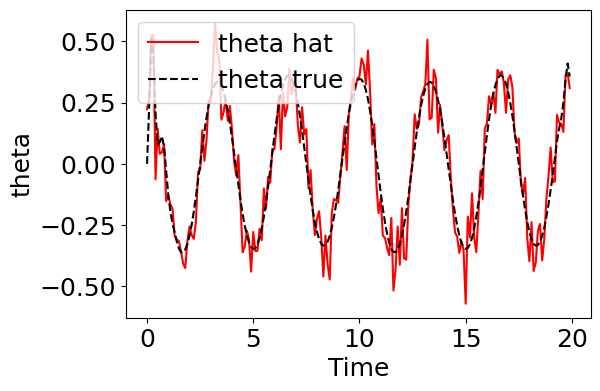

In [23]:
Q = np.eye(A.shape[0])*1e-1
xhat_fp, P_fp = linear_discrete_kalman_filter(x0, P0, Y, U, A, B, C, D, R, Q)

plot_tme(df_states.t, df_states['x'], None, estimated=xhat_fp[2,:], label_var='x')
plot_tme(df_states.t, df_states['theta'], None, estimated=xhat_fp[0,:], label_var='theta')

### Kalman filter with a smaller Q (more trust in the model)

<Axes: xlabel='Time', ylabel='theta'>

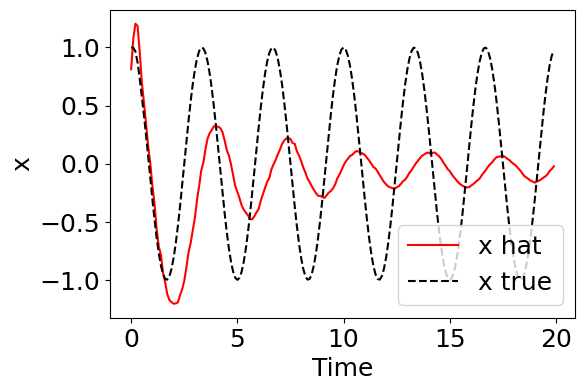

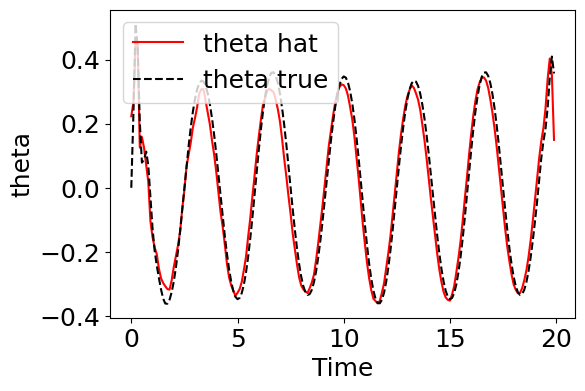

In [24]:
Q = np.eye(A.shape[0])*1e-12
xhat_fp, P_fp = linear_discrete_kalman_filter(x0, P0, Y, U, A, B, C, D, R, Q)

plot_tme(df_states.t, df_states['x'], None, estimated=xhat_fp[2,:], label_var='x')
plot_tme(df_states.t, df_states['theta'], None, estimated=xhat_fp[0,:], label_var='theta')

# Solution: Exercise 2: Compare KF error to the Cramer Rao Bound

Recall: if the KF is efficient, then the inverse of the Cramer Rao Bound should match the error covariance of the KF. 

### For a large Q

In [25]:
Q = np.eye(A.shape[0])*1e-1
xhat_fp, P_fp = linear_discrete_kalman_filter(x0, P0, Y, U, A, B, C, D, R, Q)

In [26]:
# initialize CRB
Jk = np.linalg.inv(P0)

# calculate matrix inverses
Qinv = np.linalg.inv(Q)
Rinv = np.linalg.inv(R)

# iterative CRB calculation
Js = [Jk]
for i in range(len(xhat_fp[1])):
    Jk = Js[-1]
    Jk1 = Qinv - Qinv@A@np.linalg.inv(Jk+A.T@Qinv@A)@A.T@Qinv + C.T@Rinv@C
    Js.append(Jk1)

In [27]:
# extract diagonals of the KF error covariance
Pdiags = np.vstack([np.diag(P_fp[i]) for i in range(len(P_fp))]).T
print('Pdiag shape: ', Pdiags.shape)

Pdiag shape:  (7, 200)


In [28]:
# extract diagonals of the inverse of the CRB
Jdiags = np.vstack([np.diag( np.linalg.inv(Js[i]) ) for i in range(1, len(Js))]).T
print('J shape: ', Jdiags.shape)

J shape:  (7, 200)


### Focus on the position x state [2]

In [29]:
state_of_interest = 2

Text(0, 0.5, 'Error variance')

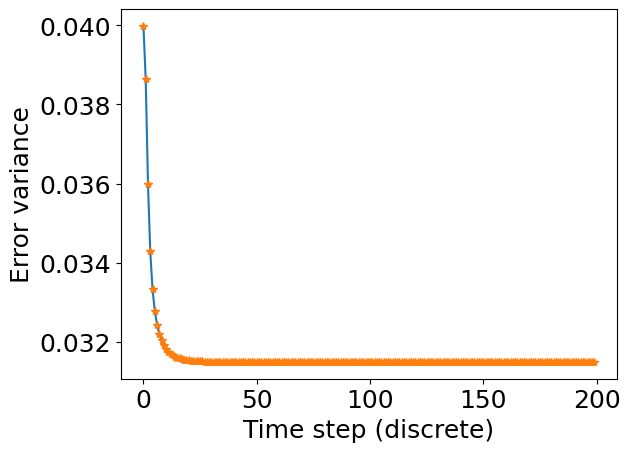

In [30]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(Pdiags[state_of_interest,:])
ax.plot(Jdiags[state_of_interest,:], '*')

ax.set_xlabel('Time step (discrete)')
ax.set_ylabel('Error variance')

# Solution: Exercise 2: Compare error variance and CRB to the actual errors

Approximately 99.7% of the errors should lie within the 3$\sigma$ bound.

### Calculate the errors and three sigma (for position x state here)

In [31]:
# errors from the KF
errors = xhat_fp[2,:] - df_states['x']

# extract the standard deviations of the error variances
sigma = Pdiags[state_of_interest,:]**0.5

# three sigma
three_sigma = 3*sigma

### Visualize as a time series

Text(0, 0.5, 'Error variance')

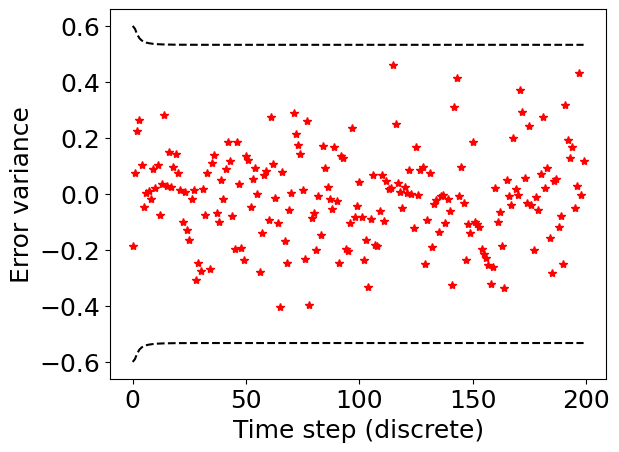

In [32]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(three_sigma, '--', color='black')
ax.plot(-1*three_sigma, '--', color='black')
ax.plot(errors, '*', color='red')

ax.set_xlabel('Time step (discrete)')
ax.set_ylabel('Error variance')

### Visualize as a histogram

Let's ignore the fact that the first few time steps have larger expected variance -- the filter converged quite quickly.

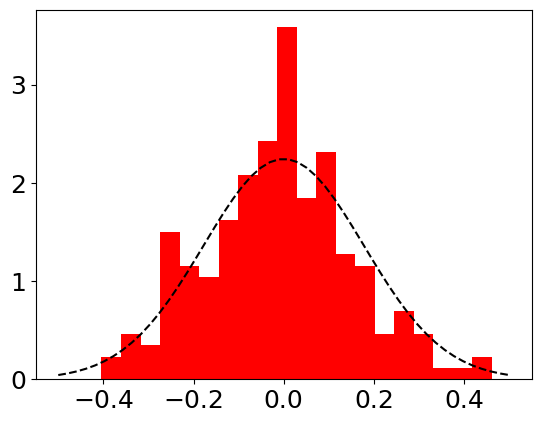

In [33]:
mean_sigma = np.mean(sigma)

fig = plt.figure()
ax = fig.add_subplot(111)

# histogram of the errors, normalized to be a probability density
ax.hist(errors, bins=20, color='red', density=True)

# normal distribution for the mean sigma from the error variance
xaxis = np.linspace(-0.5, 0.5, 50)
gauss = scipy.stats.norm(0, mean_sigma)
yaxis = gauss.pdf(xaxis)
plt.plot(xaxis, yaxis, '--', color='black')

# Bonus: Show relation between CRB and Constructability for Q=0

### Cramer Rao Bound

In [34]:
Q = np.eye(A.shape[0])*1e-16

# initialize CRB
Jk = np.linalg.inv(P0)

# calculate matrix inverses
Qinv = np.linalg.inv(Q)
Rinv = np.linalg.inv(R)

# iterative CRB calculation
Js = [Jk]
for i in range(len(xhat_fp[1])):
    Jk = Js[-1]
    Jk1 = Qinv - Qinv@A@np.linalg.inv(Jk+A.T@Qinv@A)@A.T@Qinv + C.T@Rinv@C
    Js.append(Jk1)

### Iterative Constructability

In [35]:
# initialize CRB
Jk = np.linalg.inv(P0)

# calculate matrix inverses
Qinv = np.linalg.inv(Q)
Rinv = np.linalg.inv(R)

# iterative CRB calculation
Js_noQ = [Jk]
for i in range(len(xhat_fp[1])):
    Jk = Js_noQ[-1]
    Jk1 = np.linalg.inv(A)@Jk@np.linalg.inv(A.T) + C.T@Rinv@C
    Js_noQ.append(Jk1)

### Matrix constructability

In [36]:
Ws = []

Oc = [C]
for i in range(1, len(xhat_fp[1])+1):
    bigRinv = np.diag(list(np.diag(Rinv))*i)

    Oc_stack = np.vstack(Oc)
    Wc = Oc_stack.T@bigRinv@Oc_stack
    Ws.append(Wc)
    
    Oc.append(Oc[-1]@np.linalg.inv(A))

bigRinv = np.diag(list(np.diag(Rinv))*(i+1))
Oc_stack = np.vstack(Oc)
Wc = Oc_stack.T@bigRinv@Oc_stack
Ws.append(Wc)

### Compare

In [37]:
# extract diagonals of the information matrices
# Note: if we take inverses here they become singular for tiny Q, so compare in the information domain
Jdiags = np.vstack([np.diag( (Js[i]) ) for i in range(1, len(Js))]).T
print('J shape: ', Jdiags.shape)

J_noQ_diags = np.vstack([np.diag( (Js_noQ[i]) ) for i in range(1, len(Js_noQ))]).T
print('J shape: ', J_noQ_diags.shape)

W_diags = np.vstack([np.diag( (Ws[i]) ) for i in range(1, len(Ws))]).T
print('W shape: ', W_diags.shape)

J shape:  (7, 200)
J shape:  (7, 200)
W shape:  (7, 200)


[]

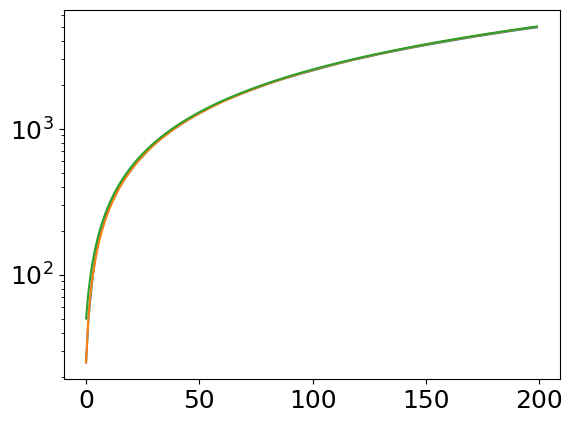

In [38]:
plt.plot(Jdiags[2,:])
plt.plot(J_noQ_diags[2,:])
plt.plot(W_diags[2,:])

plt.semilogy()